# Compare Impact-T particle and stat covariance

This is to check the interpretation of the `fort.32` covariance matrix data. Some elements are not as expected from the particles in `fort.50`:
- $<x, z>$
- $<x, pz>$
- $<y, z>$
- $<y, pz>$

In [1]:
from impact import Impact
from impact.lattice import new_write_beam

import numpy as np
from pathlib import Path
%config InlineBackend.figure_format = 'retina'

# Easier print
np.set_printoptions(formatter={'float': lambda x: f"{x:6.2e}"}, linewidth=100)

def printsymmat(matrix):
    for i in range(6):
        for j in range(6):
            if j < i:
                print(f"{' ':>8}", end=" ")  # Print '-' for redundant lower triangle elements
            else:
                print(f"{matrix[i][j]:8.2f}", end=" ")  # Print the number for upper triangle and diagonal
        print()  # New line for each row

# Make data

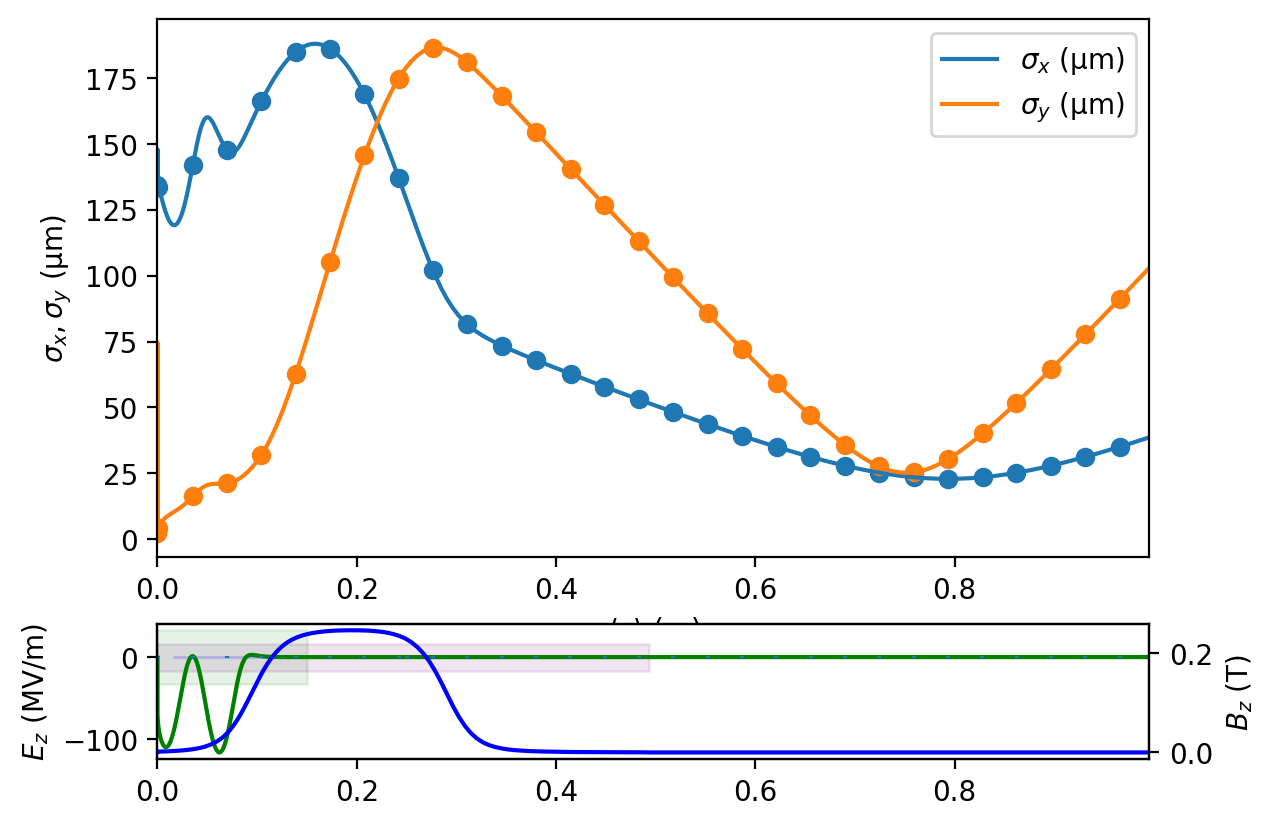

In [2]:
ifile = 'templates/lcls_injector/ImpactT.in'
I = Impact(ifile)
I.header['Np'] = 1000
# Turn Space Charge off. Both these syntaxes work
I.header['Bcurr'] = 0 
I.stop = 1
I.numprocs = 4
# Make a list of s
for s in np.linspace(0.001, 1, 30):
    ele = new_write_beam(s=s, ref_eles=I.lattice) # ref_eles will ensure that there are no naming conflicts
    I.add_ele(ele)
I.run()
I.plot()

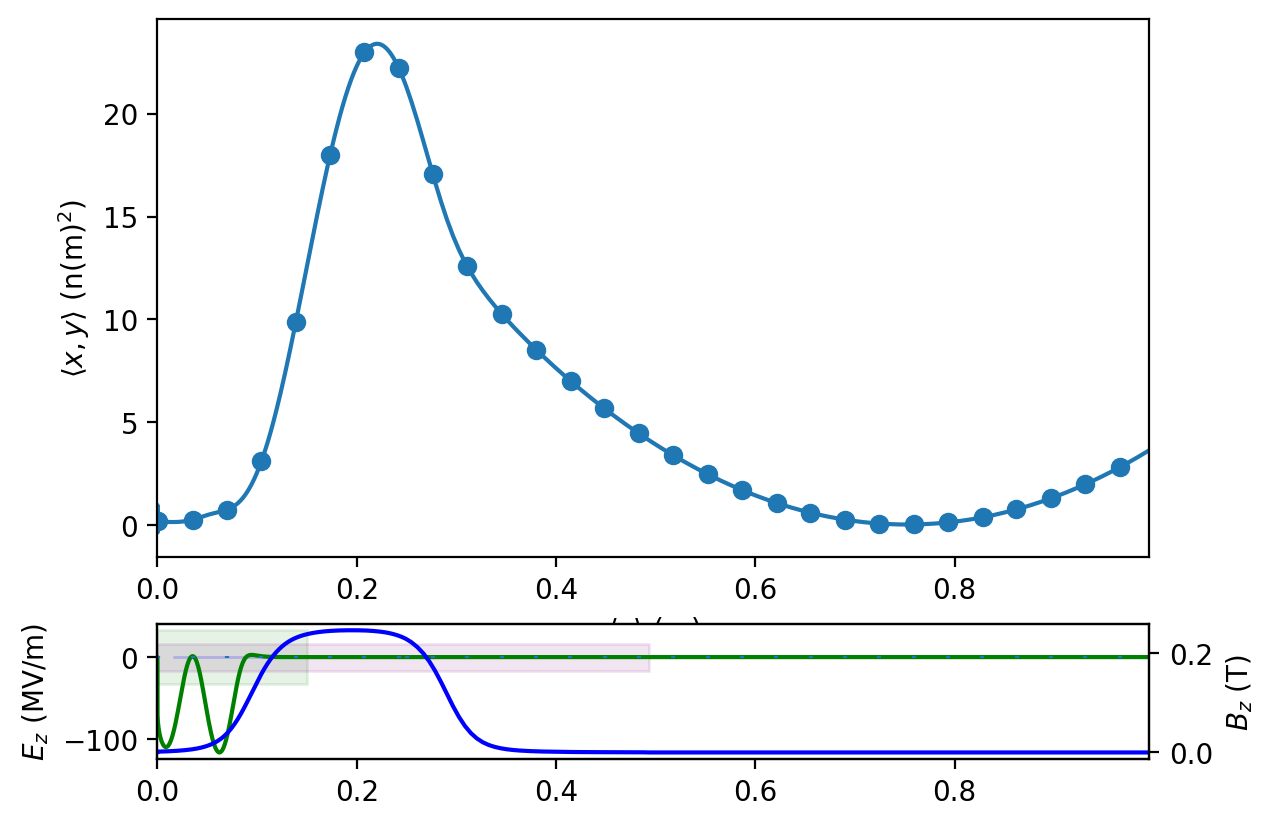

In [3]:
# This is good
I.plot('cov_x__y')

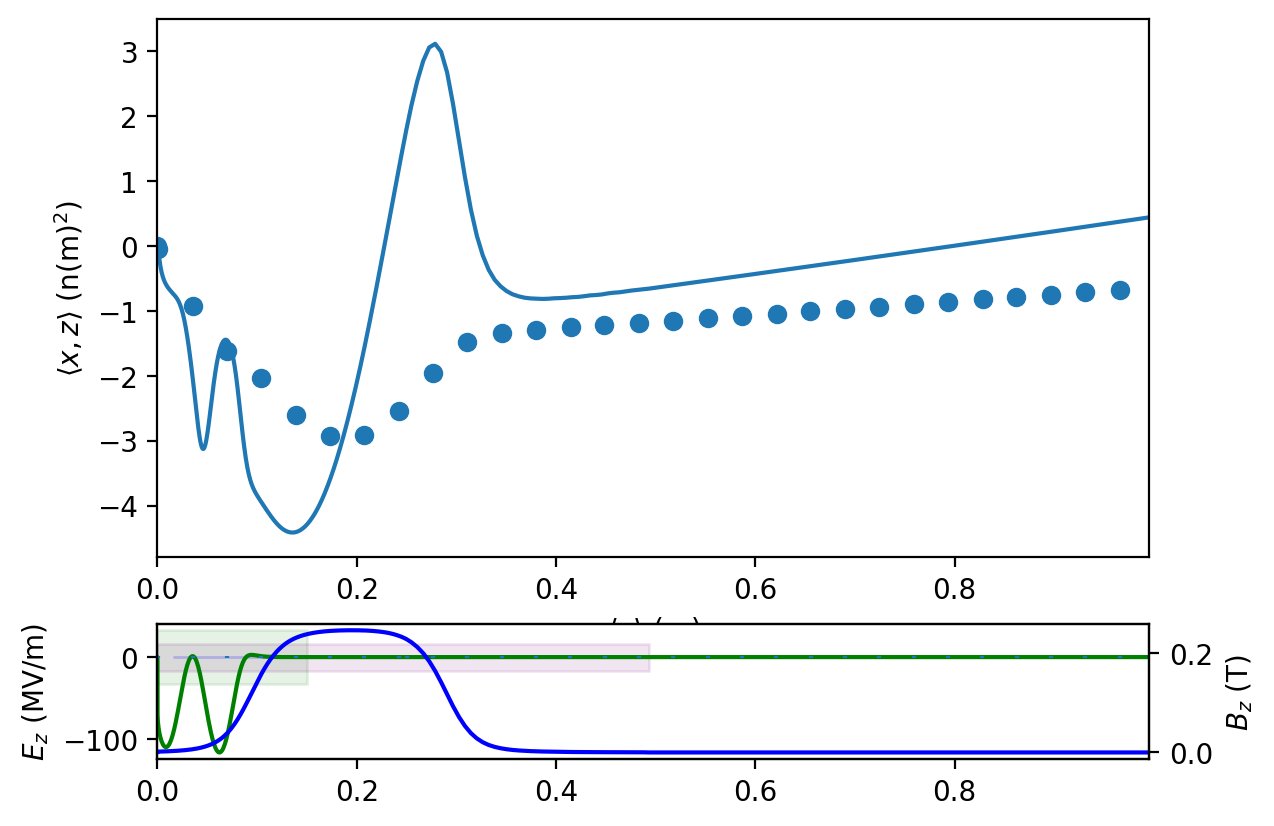

In [4]:
# This is bad
I.plot('cov_x__z')

# fort.32 covariance matrix data

Load and label the data

In [5]:
root =  Path(I.path)

In [6]:
fdat = np.loadtxt(root/'fort.32')[-1, :]
labels = ['z',
 'z0avg*xl',
 'xl',
 'sqsum1',
 'xpx',
 'xy',
 'xpy',
 'xz',
 'xpz',
 'sqsum2',
 'ypx',
 'pxpy',
 'zpx',
 'pxpz',
 'sqsum3',
 'ypy',
 'yz',
 'ypz',
 'sqsum4',
 'zpy',
 'pypz',
 'sqsum5',
 'zpz',
 'sqsum6']
fstat = {}
for label, dat in zip(labels, fdat):
    fstat[label] = dat

xl = fstat['xl']
fstat

{'z': 3.3522667e-09,
 'z0avg*xl': 0.99556375,
 'xl': 0.00014989623,
 'sqsum1': 0.066621311,
 'xpx': 0.00037482215,
 'xy': 0.16242509,
 'xpy': 0.0011346002,
 'xz': 0.019748491,
 'xpz': 0.00012420264,
 'sqsum2': 3.2497525e-06,
 'ypx': 0.001184492,
 'pxpy': 8.3563017e-06,
 'zpx': 8.4588123e-05,
 'pxpz': 2.768486e-07,
 'sqsum3': 0.47249852,
 'ypy': 0.003195693,
 'yz': 0.0419781,
 'ypz': 0.00032294081,
 'sqsum4': 2.2991086e-05,
 'zpy': 0.00021231046,
 'pypz': 7.8974858e-07,
 'sqsum5': 3.7375573,
 'zpz': 0.00023807697,
 'sqsum6': 3.6262376e-06}

In [7]:
F = fstat
fcov = np.array([
     [F['sqsum1'] * xl**2, F['xpx']*xl, F['xy']*xl**2, F['xpy']*xl, F['xz']*xl**2, F['xpz']*xl],
      [0,                   F['sqsum2'], F['ypx']*xl, F['pxpy'], F['zpx']*xl, F['pxpz']],
      [0, 0, F['sqsum3']*xl**2, F['ypy']*xl, F['yz']*xl**2, F['ypz']*xl],
      [0, 0, 0, F['sqsum4'], F['zpy']*xl, F['pypz']],
      [0, 0, 0,0, F['sqsum5']*xl**2, F['zpz']*xl],
      [0, 0, 0, 0, 0,  F['sqsum6']],
    ])
# Make the matrix symmetric by copying upper triangle to lower triangle
for i in range(6):
    for j in range(6):
        fcov[j, i] = fcov[i, j]


fcov*1e9

array([[1.50e+00, 5.62e+01, 3.65e+00, 1.70e+02, 4.44e-01, 1.86e+01],
       [5.62e+01, 3.25e+03, 1.78e+02, 8.36e+03, 1.27e+01, 2.77e+02],
       [3.65e+00, 1.78e+02, 1.06e+01, 4.79e+02, 9.43e-01, 4.84e+01],
       [1.70e+02, 8.36e+03, 4.79e+02, 2.30e+04, 3.18e+01, 7.90e+02],
       [4.44e-01, 1.27e+01, 9.43e-01, 3.18e+01, 8.40e+01, 3.57e+01],
       [1.86e+01, 2.77e+02, 4.84e+01, 7.90e+02, 3.57e+01, 3.63e+03]])

In [8]:
print('fort.32 with xl scaling (* 1e9)')
printsymmat(fcov*1e9) 

fort.32 with xl scaling (* 1e9)
    1.50    56.18     3.65   170.07     0.44    18.62 
          3249.75   177.55  8356.30    12.68   276.85 
                     10.62   479.02     0.94    48.41 
                           22991.09    31.82   789.75 
                                       83.98    35.69 
                                              3626.24 


# Final particles from fort.50

Calculate the covariance matrix


In [9]:
pdat = np.loadtxt(root/'fort.50')
pdat.shape

(1000, 6)

In [10]:
# Covariance
cov = np.cov(pdat.T)
cov.shape

print('fort.50 with np.cov (* 1e9)')
printsymmat(cov*1e9) 

fort.50 with np.cov (* 1e9)
    1.54    57.47     3.79   173.44    -0.60     6.05 
          3253.01   180.93  8364.67    12.70   277.13 
                     10.99   488.23    -1.67    16.90 
                           23014.10    31.87   790.54 
                                       84.06    35.73 
                                              3629.87 


# <x, z> disagrees

In [11]:
# Particles <x, z>
cov[0, 4]

-6.016808304055663e-10

In [12]:
# Equivalent fort.32
fstat['xz']* xl**2

4.4372646988263457e-10

#  <x, pz>

In [13]:
# Particles <x, pz>
cov[0, 5]

6.049617033381982e-09

In [14]:
# Particles <x, pz>
fstat['xpz']* xl

1.8617507492047203e-08

 # <x, y> agrees somewhat

In [15]:
cov[0, 2]

3.785463908986497e-09

In [16]:
fstat['xy']*xl*xl

3.64950981855116e-09

# LUME-Impact plots

In [17]:
#from impact import Impact
#%config InlineBackend.figure_format = 'retina'
#
#I = Impact('ImpactT.in', workdir = '.', use_temp_dir=False)
#I.load_output()

#I.plot('cov_x__z')

In [18]:
#I.plot('cov_x__y')